In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from power_ksamp import power_ksamp_sample
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.tools import *

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:])

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [3]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][0, 1]

        return stat

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [5]:
SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
    MGC,
    Dcorr,
    Hsic,
    Manova,
    HHG,
    CCA,
    RV,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [6]:
RENAME_TESTS = {
    "Dcorr": "Energy",
    "Hsic": "MMD"
}

def estimate_power(sim, test):
    est_power = np.array([np.mean([power_ksamp_sample(test, rot_ksamp, sim, n=i, noise=True) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../ksample/ksamp_vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [7]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.3min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 24.6min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 64.4min
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 82.3min
[Paralle

Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 120.8min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed: 121.0min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 121.1min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 123.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed: 129.2min
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 134.3min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 141.8min
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed: 145.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 148.9min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 149.5min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 149.8min
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed: 155.5min
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed: 160.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 164.3min
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed: 167.7min
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed: 168.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 170.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 175.6min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 180.3min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed: 192.4min
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed: 193.0min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 195.7min
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed: 197.8min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed: 198.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 207.8min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 225.7min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 226.0min
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed: 243.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 246.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 247.0min
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed: 248.9min
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed: 257.5min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed: 262.6min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 274.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 325.9min
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed: 328.7min
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed: 331.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 336.7min
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed: 344.7min
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed: 360.8min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 376.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 378.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 381.5min
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed: 384.2min
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed: 418.1min
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed: 427.9min
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed: 445.0min
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed: 461.6min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 4

Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 541.8min
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed: 550.1min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 551.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 553.3min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 553.9min
[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed: 554.7min
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed: 555.9min
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed: 563.3min
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed: 569.2min
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed: 573.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 573.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 575.3min
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed: 575.8min
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed: 576.4min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed: 586.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 597.0min
[Parallel(n_jobs=-1)]: Done 111 out of 140 | elapsed: 599.4min remaining: 156.6min
[Parallel(n_jobs=-1)]: Done 113 out of 140 | elapsed: 602.4min remaining: 143.9min
[Parallel(n_jobs=-1)]: Done 115 out of 140 | elapsed: 623.9min remaining: 135.6min
[Parallel(n_jobs=-1)]: Done 117 out of 140 | elapsed: 639.5min remaining: 125.7min
[Parallel(n_jobs=-1)]: Done 119 out of 140 | elapsed: 650.7min remaining: 114.8min
[Parallel(n_jobs=-1)]: Done 121 out of 140 | elapsed: 661.5min remaining: 103.9min


Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


[Parallel(n_jobs=-1)]: Done 123 out of 140 | elapsed: 679.8min remaining: 94.0min
[Parallel(n_jobs=-1)]: Done 125 out of 140 | elapsed: 682.3min remaining: 81.9min
[Parallel(n_jobs=-1)]: Done 127 out of 140 | elapsed: 685.0min remaining: 70.1min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 129 out of 140 | elapsed: 699.9min remaining: 59.7min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 131 out of 140 | elapsed: 722.0min remaining: 49.6min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 133 out of 140 | elapsed: 750.8min remaining: 39.5min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 135 out of 140 | elapsed: 815.0min remaining: 30.2min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 137 out of 140 | elapsed: 856.8min remaining: 18.8min


R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 891.4min finished


The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [8]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Three-Sample Testing Increasing Sample Size", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../ksample/ksamp_vs_samplesize/{}_{}.csv'.format(sim, test_name),
                                      delimiter=',')
                manova_power = np.genfromtxt('../ksample/ksamp_vs_samplesize/{}_Manova.csv'.format(sim), delimiter=',')

                if test_name == "MGC":
                    col.plot(SAMP_SIZES, power - manova_power, color="#e41a1c", label=test_name, lw=4)
                else:
                    col.plot(SAMP_SIZES, power - manova_power, label=test_name, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to Manova', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../ksample/figs/ksamp_power_sampsize.pdf', transparent=True, bbox_inches='tight')

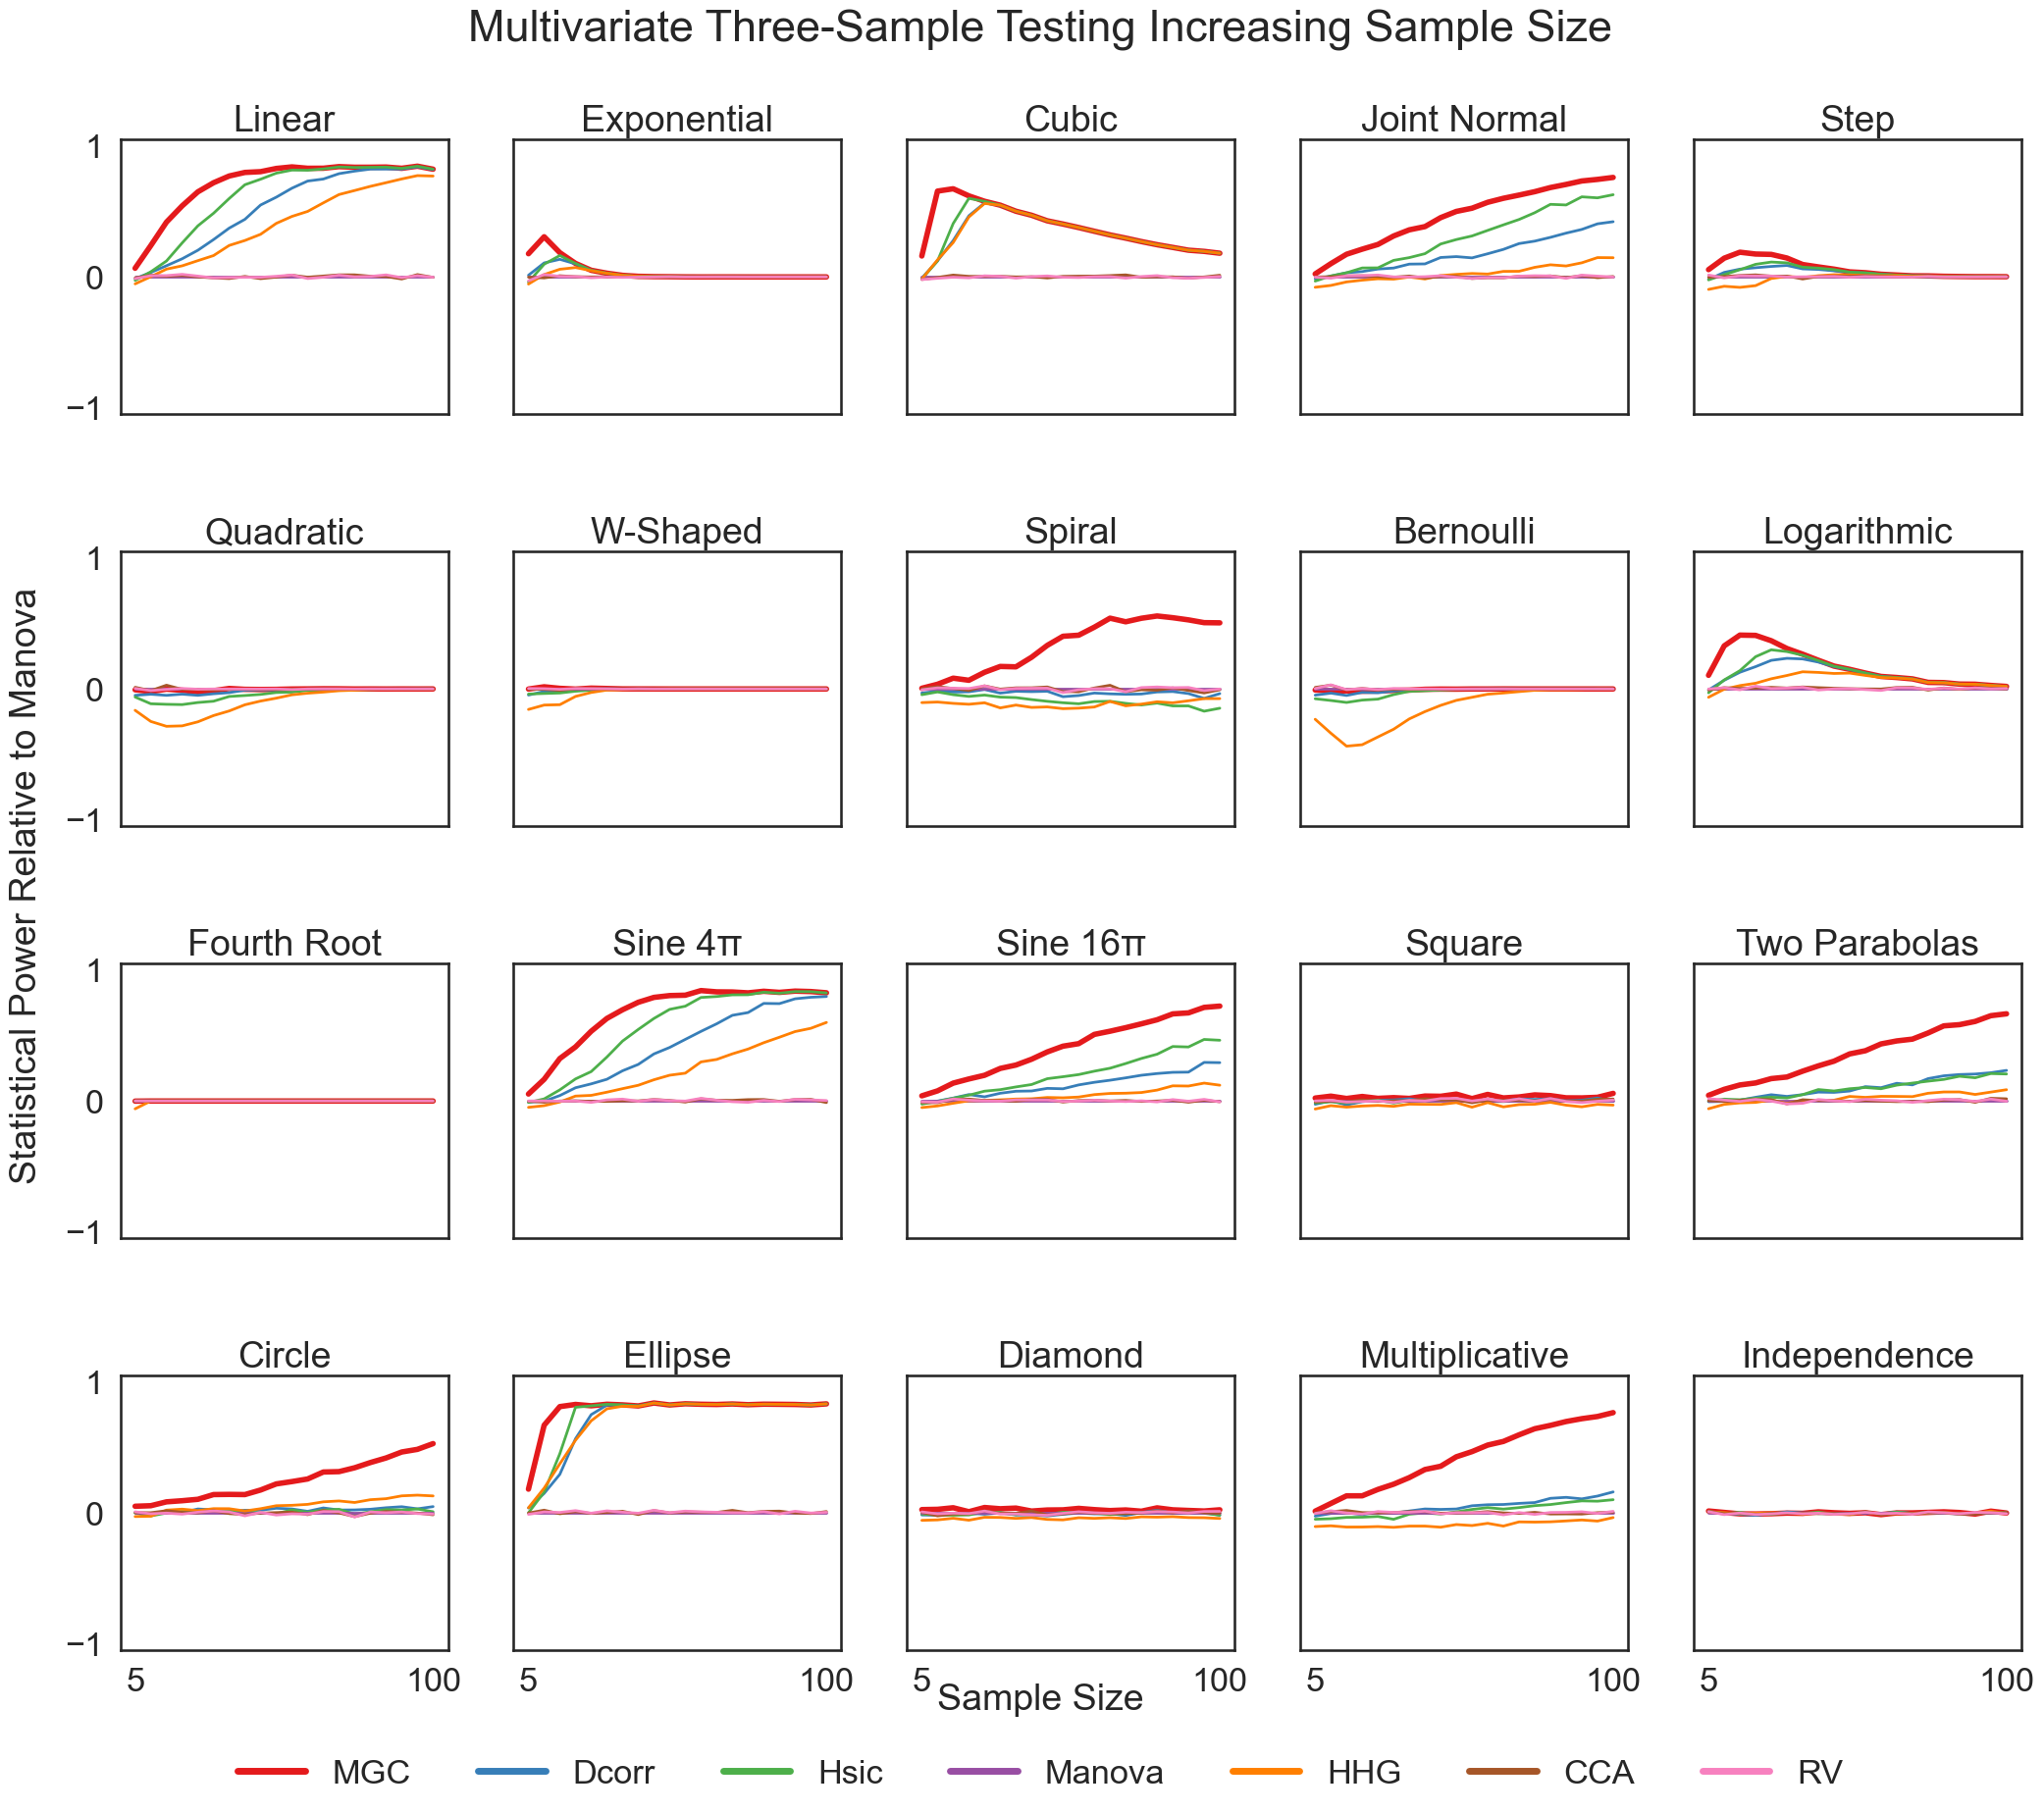

In [9]:
plot_power()